In [2]:
try:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
except NameError:
    pass

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os.path as osp

import torch
from sklearn.svm import SVC

from cifar_loader import load_cifar_dataset
from utils import shuffle_multiple_arrays, fit_and_save, eval_and_plot

In [4]:
seed = 34
save_dir = "models"

### Prepare data

In [48]:
orig_train_images, orig_train_labels, orig_test_images, orig_test_labels, class_names = (
    load_cifar_dataset("cifar-10-batches-py"))
train_images, train_labels = shuffle_multiple_arrays(orig_train_images, orig_train_labels, seed=seed)
test_images, test_labels = shuffle_multiple_arrays(orig_test_images, orig_test_labels, seed=seed)

In [74]:
X_train = train_images.reshape(len(train_images), -1)
X_test = test_images.reshape(len(test_images), -1)
y_train = train_labels
y_test = test_labels


subsample_fraction = 0.01
num_train = int(len(X_train) * subsample_fraction)
num_test = int(len(X_test) * subsample_fraction)
X_train, y_train, X_test, y_test = X_train[:num_train], y_train[:num_train], X_test[:num_test], y_test[:num_test]
print(f"num_train: {num_train}   num_test: {num_test}")

num_train: 500   num_test: 100


## Linear SVM

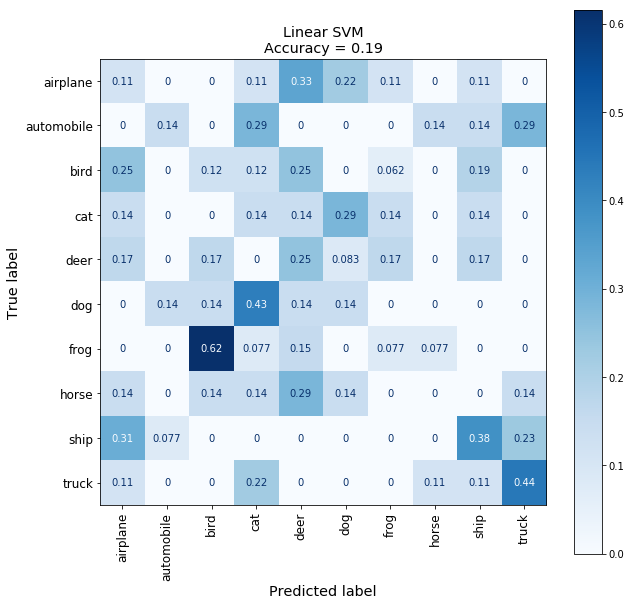

In [75]:
model = SVC(kernel="linear", random_state=seed)
model_name = "linear_svm"
model_display_name = "Linear SVM"

fit_and_save(model, X_train, y_train,
             save_dir, model_name)

eval_and_plot(model, X_test, y_test,
              class_names, save_dir, model_name, model_display_name)

## SVM with RBF Kernel

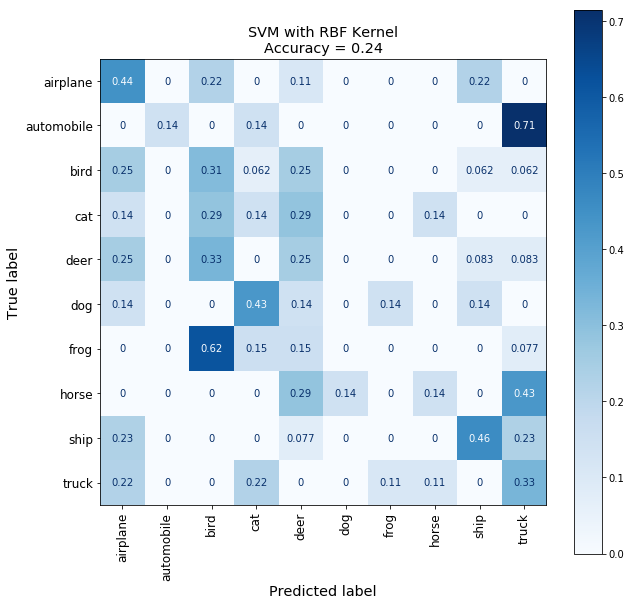

In [76]:
model = SVC(kernel="rbf", random_state=seed)
model_name = "rbf_svm"
model_display_name = "SVM with RBF Kernel"

fit_and_save(model, X_train, y_train,
             save_dir, model_name)

eval_and_plot(model, X_test, y_test,
              class_names, save_dir, model_name, model_display_name)

## Playing around with PyTorch low level api

In [87]:
torch.manual_seed(seed)
np_state = np.random.RandomState(seed)

# create very easy binary classification dataset
x0 = np_state.randn(100, 10) * 3
x1 = np_state.randn(100, 10) * 7
x = np.vstack([x0, x1])
y = np.array([0] * len(x0) + [1] * len(x1))
perm = np_state.permutation(len(x))
x = x[perm]
y = y[perm]
x = torch.Tensor(x)
y = torch.Tensor(y)

# create variables for hidden layer and classifier layer
W1 = torch.autograd.Variable(torch.randn((10,100)), requires_grad=True)
W2 = torch.autograd.Variable(torch.randn((100,1)), requires_grad=True)
optimizer = torch.optim.Adam([W1, W2], lr=0.001)

iters = 1000
for i in range(iters):
    # forward pass
    h = torch.tanh(torch.matmul(x, W1))
#     h = torch.relu(torch.matmul(x, W1))
#     h = torch.sigmoid(torch.matmul(x, W1))
    p = torch.squeeze(torch.sigmoid(torch.matmul(h, W2)))
    
    # loss calculation
    eps = torch.Tensor([1e-4])
    p = torch.min(p, 1-eps)
    p = torch.max(p, eps)
    loss = - (y * torch.log(p) + (1 - y) * torch.log(1 - p))
    loss = torch.mean(loss)
    
    # report progress
    if ((i+1) % (iters//10) == 0) or (i == 0):
        accuracy = ((p > 0.5).int() == y).float().mean()
        print(f"{i+1}/{iters}  loss: {loss.item():.3f}   accuracy: {accuracy.item():.2f}")
    
    # gradient step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print()
print("my loss implementation VS pytorch loss implementation:")
print("pytorch:", torch.nn.BCELoss()(p, y).item())
print("mine:   ", loss.item())

1/1000  loss: 3.705   accuracy: 0.45
100/1000  loss: 1.832   accuracy: 0.70
200/1000  loss: 0.970   accuracy: 0.81
300/1000  loss: 0.765   accuracy: 0.90
400/1000  loss: 0.710   accuracy: 0.92
500/1000  loss: 0.658   accuracy: 0.93
600/1000  loss: 0.630   accuracy: 0.93
700/1000  loss: 0.619   accuracy: 0.94
800/1000  loss: 0.527   accuracy: 0.94
900/1000  loss: 0.344   accuracy: 0.96
1000/1000  loss: 0.338   accuracy: 0.96

my loss implementation VS pytorch loss implementation:
pytorch: 0.33822545409202576
mine:    0.33822551369667053
